# (E13) 프로젝트 : 주식 예측에 도전해 보자

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller


## Data Load

- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있지만, 우리는 Close만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

Date
2000-01-04    6110.0
2000-01-05    5580.0
2000-01-06    5620.0
2000-01-07    5540.0
2000-01-10    5770.0
Name: Close, dtype: float64

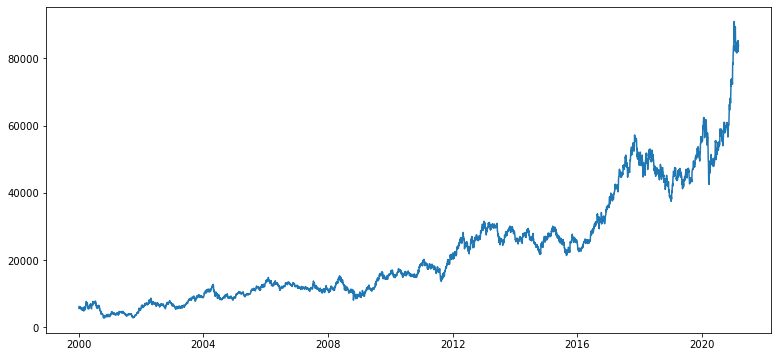

In [2]:
# Data Load
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/005930.KS.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

# Time Series 생성
rcParams['figure.figsize'] = 13, 6
plt.plot(ts)

ts.head()

## Data preprocessing

- 결측치 처리
- 로그 변환

In [3]:
# 결측치 처리
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Date
2005-01-03   NaN
2017-11-16   NaN
2017-11-23   NaN
2018-01-02   NaN
2018-11-15   NaN
2019-11-14   NaN
Name: Close, dtype: float64

Series([], Name: Close, dtype: float64)


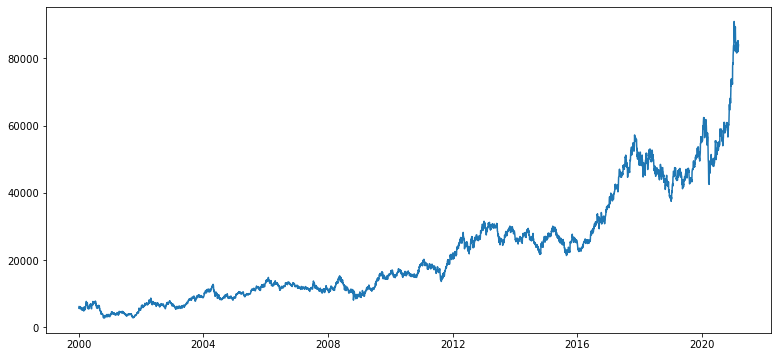

In [4]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
ts=ts.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인합니다.
print(ts[ts.isna()])

plt.plot(ts)

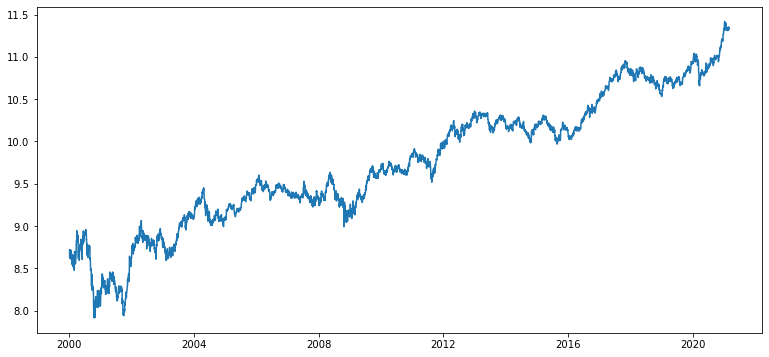

In [5]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

## Rolling Statistics 시각화

In [6]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

## Augmented Dickey-Fuller Test

In [7]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

## 시계열 안정성 분석

- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

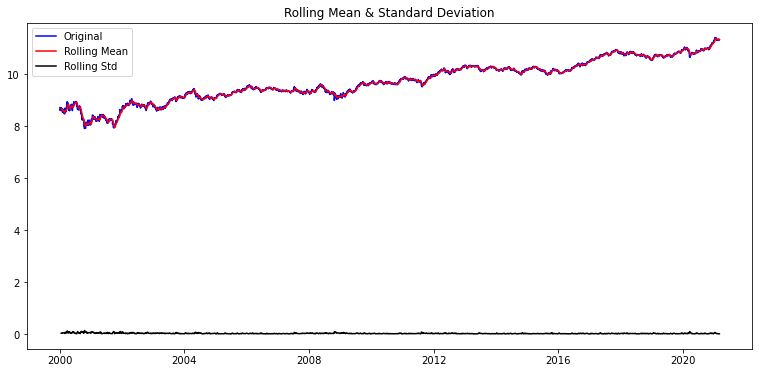

Results of Dickey-Fuller Test:
Test Statistic                   -0.300283
p-value                           0.925464
#Lags Used                        4.000000
Number of Observations Used    5315.000000
Critical Value (1%)              -3.431581
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64


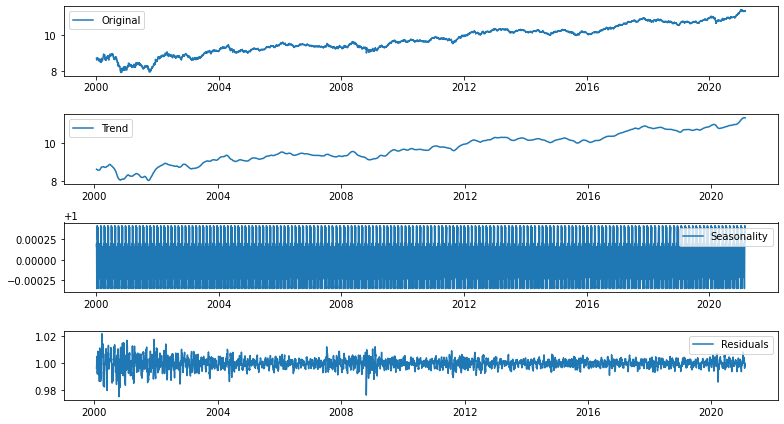

In [8]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

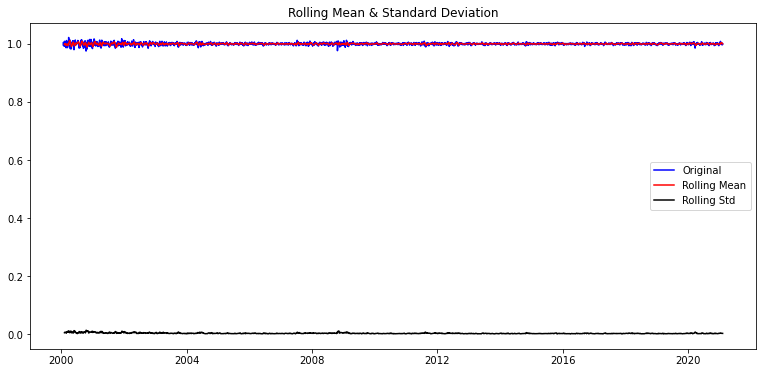

In [9]:
# Residual 안정성 확인
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [10]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.760269e+01
p-value                        3.914322e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.256000e+03
Critical Value (1%)           -3.431595e+00
Critical Value (5%)           -2.862090e+00
Critical Value (10%)          -2.567063e+00
dtype: float64


## 학습, 테스트 데이터셋 생성

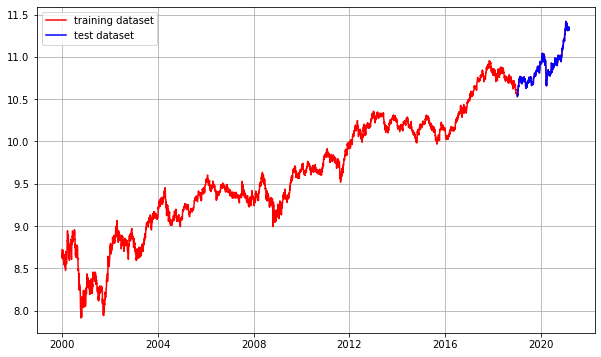

In [11]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [12]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2000-01-04    8.717682
2000-01-05    8.626944
Name: Close, dtype: float64
(4788,)
(532,)


## 적정 ARIMA 모수 찾기

- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

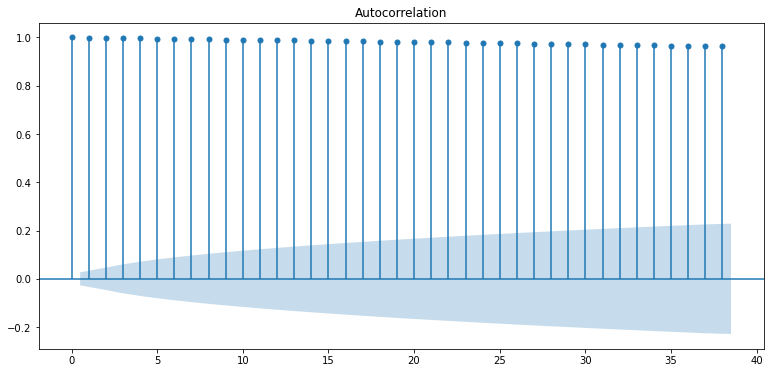

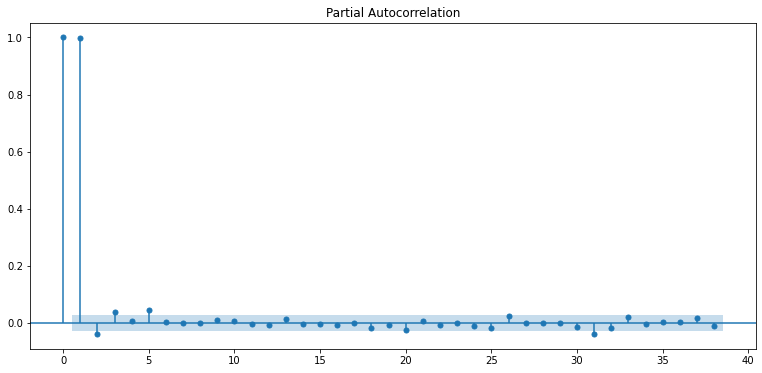

In [13]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -40.107780
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    5315.000000
Critical Value (1%)              -3.431581
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64


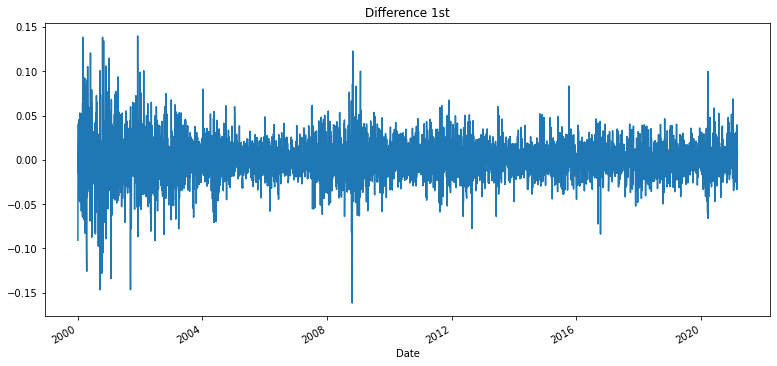

In [14]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

## ARIMA 모델 훈련과 테스트

- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [15]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4787
Model:                 ARIMA(1, 1, 0)   Log Likelihood               11282.237
Method:                       css-mle   S.D. of innovations              0.023
Date:                Thu, 04 Mar 2021   AIC                         -22558.473
Time:                        01:13:08   BIC                         -22539.052
Sample:                             1   HQIC                        -22551.651
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.000      1.093      0.275      -0.000       0.001
ar.L1.D.Close     0.0436      0.014      3.017      0.003       0.015       0.072
                                    Root

/home/aiffel-dj22/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj22/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

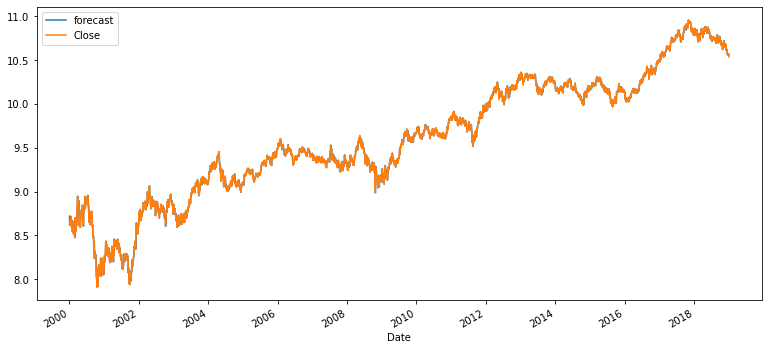

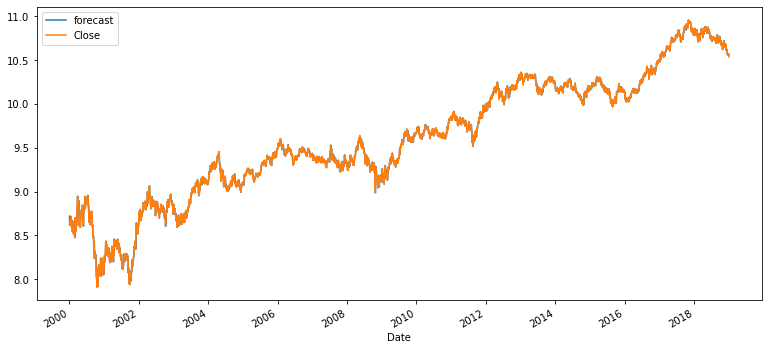

In [16]:
fitted_m.plot_predict()

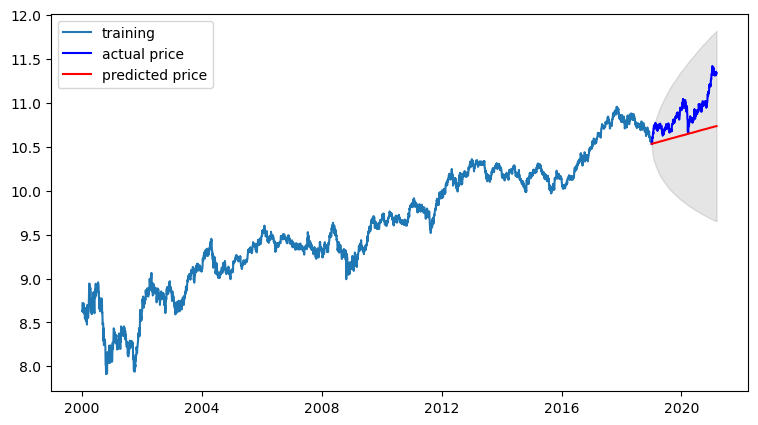

In [17]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  255620975.71648255
MAE:  12827.418269711668
RMSE:  15988.151103754384
MAPE: 21.45%


## 다른 주식 종목 예측

## Johnson & Johnson (JNJ)

Date
2000-01-03    46.09375
2000-01-04    44.40625
2000-01-05    44.87500
2000-01-06    46.28125
2000-01-07    48.25000
Name: Close, dtype: float64

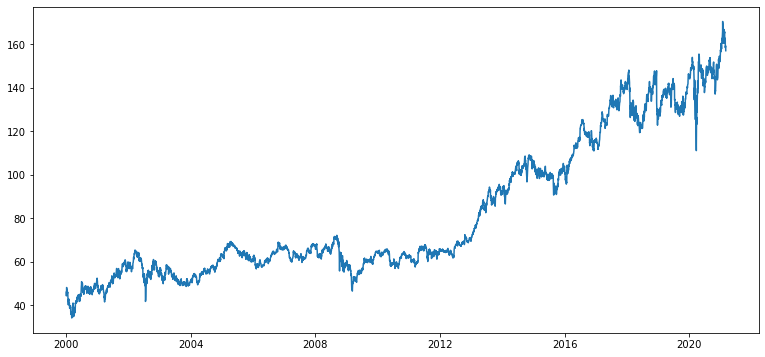

In [27]:
# Data Load
dataset_jnj_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/JNJ.csv' 
df_jnj = pd.read_csv(dataset_jnj_filepath, index_col='Date', parse_dates=True)
ts_jnj = df_jnj['Close']

# Time Series 생성
rcParams['figure.figsize'] = 13, 6
plt.plot(ts_jnj)

ts_jnj.head()

In [28]:
# 결측치 처리
ts_jnj[ts_jnj.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

Series([], Name: Close, dtype: float64)


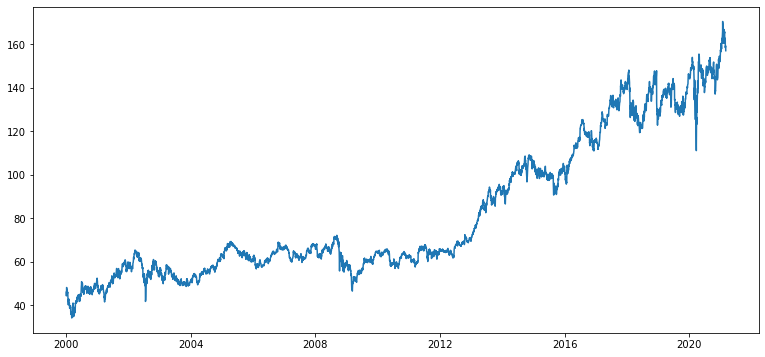

In [29]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
ts_jnj=ts_jnj.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인합니다.
print(ts_jnj[ts_jnj.isna()])

plt.plot(ts_jnj)

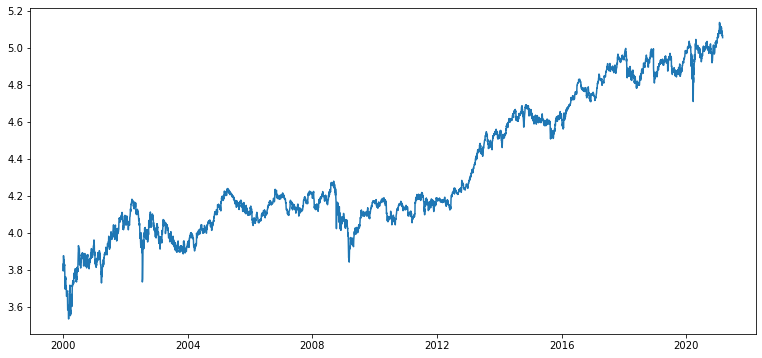

In [30]:
# 로그 변환
ts_jnj_log = np.log(ts_jnj)
plt.plot(ts_jnj_log)

In [31]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  
    rolstd = timeseries.rolling(window=window).std()

    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [32]:
def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')  
    
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

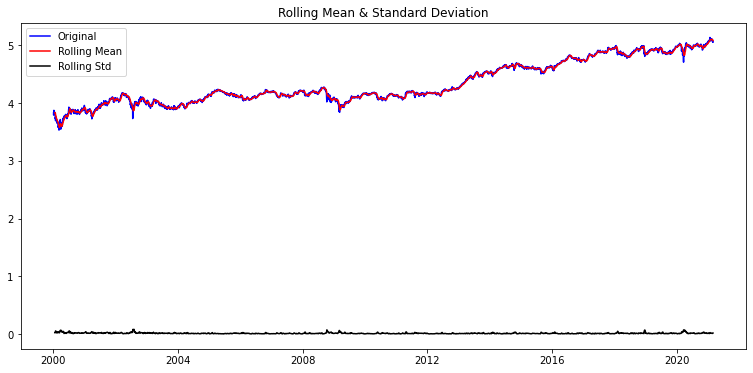

Results of Dickey-Fuller Test:
Test Statistic                   -0.719206
p-value                           0.841712
#Lags Used                       17.000000
Number of Observations Used    5307.000000
Critical Value (1%)              -3.431583
Critical Value (5%)              -2.862085
Critical Value (10%)             -2.567060
dtype: float64


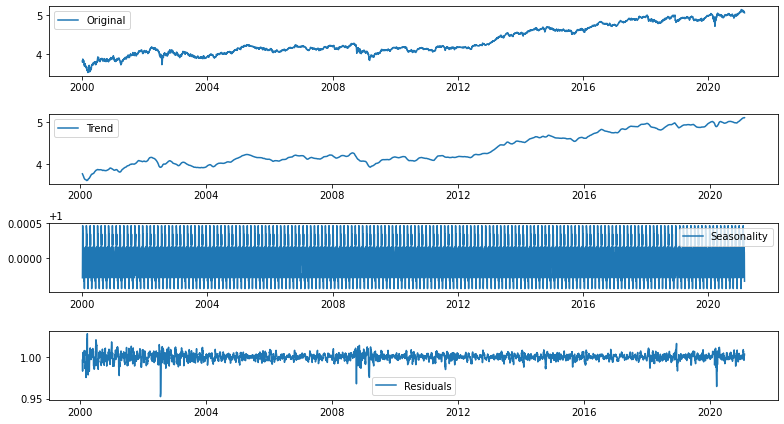

In [33]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_jnj_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_jnj_log)

#시계열 분해 (Time Series Decomposition)
decomposition_jnj = seasonal_decompose(ts_jnj_log, model='multiplicative', period = 30) 

trend_jnj = decomposition_jnj.trend
seasonal_jnj = decomposition_jnj.seasonal
residual_jnj = decomposition_jnj.resid

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_jnj_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_jnj, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_jnj,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_jnj, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [34]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.760269e+01
p-value                        3.914322e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.256000e+03
Critical Value (1%)           -3.431595e+00
Critical Value (5%)           -2.862090e+00
Critical Value (10%)          -2.567063e+00
dtype: float64


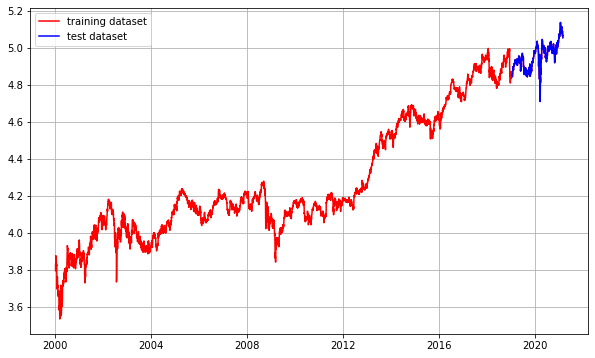

In [35]:
train_data, test_data = ts_jnj_log[:int(len(ts_jnj_log)*0.9)], ts_jnj_log[int(len(ts_jnj_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_jnj_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [ ]:
print(ts_jnj_log[:2])
print(train_data.shape)
print(test_data.shape)

In [ ]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

In [ ]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

In [ ]:
fitted_m.plot_predict()

In [ ]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))